In [1]:
import json
import functools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
df = pd.read_parquet("Dataset-Unicauca-Version2-87Atts.parquet")
df.info(verbose=True, null_counts=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577296 entries, 0 to 3577295
Data columns (total 87 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Flow.ID                      3577296 non-null  object 
 1   Source.IP                    3577296 non-null  object 
 2   Source.Port                  3577296 non-null  int64  
 3   Destination.IP               3577296 non-null  object 
 4   Destination.Port             3577296 non-null  int64  
 5   Protocol                     3577296 non-null  int64  
 6   Timestamp                    3577296 non-null  object 
 7   Flow.Duration                3577296 non-null  int64  
 8   Total.Fwd.Packets            3577296 non-null  int64  
 9   Total.Backward.Packets       3577296 non-null  int64  
 10  Total.Length.of.Fwd.Packets  3577296 non-null  int64  
 11  Total.Length.of.Bwd.Packets  3577296 non-null  float64
 12  Fwd.Packet.Length.Max        3577296 non-n

,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,...,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
0,172.19.1.46-10.200.7.7-52422-3128-6,172.19.1.46,52422,10.200.7.7,3128,6,26/04/201711:11:17,45523,22,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
1,172.19.1.46-10.200.7.7-52422-3128-6,10.200.7.7,3128,172.19.1.46,52422,6,26/04/201711:11:17,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
2,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,1,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
3,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,217,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
4,192.168.72.43-10.200.7.7-55961-3128-6,192.168.72.43,55961,10.200.7.7,3128,6,26/04/201711:11:17,78068,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY


In [3]:
@functools.lru_cache(maxsize=10000)
def _ip_to_int(ip):
    octets = [int(octet) for octet in ip.split(".")]
    return 16777216*octets[0] + 65536*octets[1] + 256*octets[2] + octets[3]

In [4]:
df.drop(columns=["Flow.ID", "Timestamp"], inplace=True)
df["Source.IP"] = df["Source.IP"].apply(_ip_to_int)
df["Destination.IP"] = df["Destination.IP"].apply(_ip_to_int)
df["Total.Length.of.Bwd.Packets"] = df["Total.Length.of.Bwd.Packets"].astype(int)
df = pd.get_dummies(df, columns=["Protocol"])
df.rename(columns={"Protocol_0": "Protocol.Other",
                   "Protocol_6": "Protocol.TCP",
                   "Protocol_17": "Protocol.UDP"}, inplace=True)
df.drop(columns=["Fwd.Header.Length.1", "Label"], inplace=True)  # copied col, and const value (BENIGN)
classes_to_keep = set(df["ProtocolName"].value_counts(ascending=False).head(50).index)
protocol_encoder = {protocol: i for i, protocol in enumerate(sorted(classes_to_keep))}
with open("protocol_name_encoding.json", "w") as f:
    json.dump(protocol_encoder, f, indent=4)
df = df[df["ProtocolName"].isin(classes_to_keep)]
df.reset_index(inplace=True, drop=True)
df["target"] = df["ProtocolName"].map(protocol_encoder)
df.drop(columns=["L7Protocol"], inplace=True)
df.drop(columns=df.columns[df.nunique() == 1], inplace=True)
df.drop_duplicates(inplace=True, ignore_index=True)
print(f"Non-numerical features: {df.select_dtypes(exclude=['int', 'float', 'uint8']).columns.to_list()}")
print(f"Shape: {df.shape}")

Non-numerical features: ['ProtocolName']
Shape: (3567193, 75)


In [5]:
profile = ProfileReport(df, minimal=True)
profile.to_file("data_summary.html")

In [6]:
# profile = ProfileReport(df, missing_diagrams=[], duplicates=[], interactions=[],
#                         correlations={"spearman": True,
#                                       "kendall": False,
#                                       "phi_k": False,
#                                       "cramers": False})
# profile.to_file(output_file="data_summary.html")

# profile = ProfileReport(df, missing_diagrams=[], duplicates=[], interactions=[],
#                         correlations={"pearson": {"calculate": True},
#                                       "spearman": {"calculate": False},
#                                       "kendall": {"calculate": False},
#                                       "phi_k": {"calculate": False},
#                                       "cramers": {"calculate": False}})
# profile.to_file(output_file="./metadata_preprocessing/data_summary.html")

In [7]:
corr = pd.read_csv("./metadata_preprocessing/correlation.csv", index_col=0)

<AxesSubplot:>

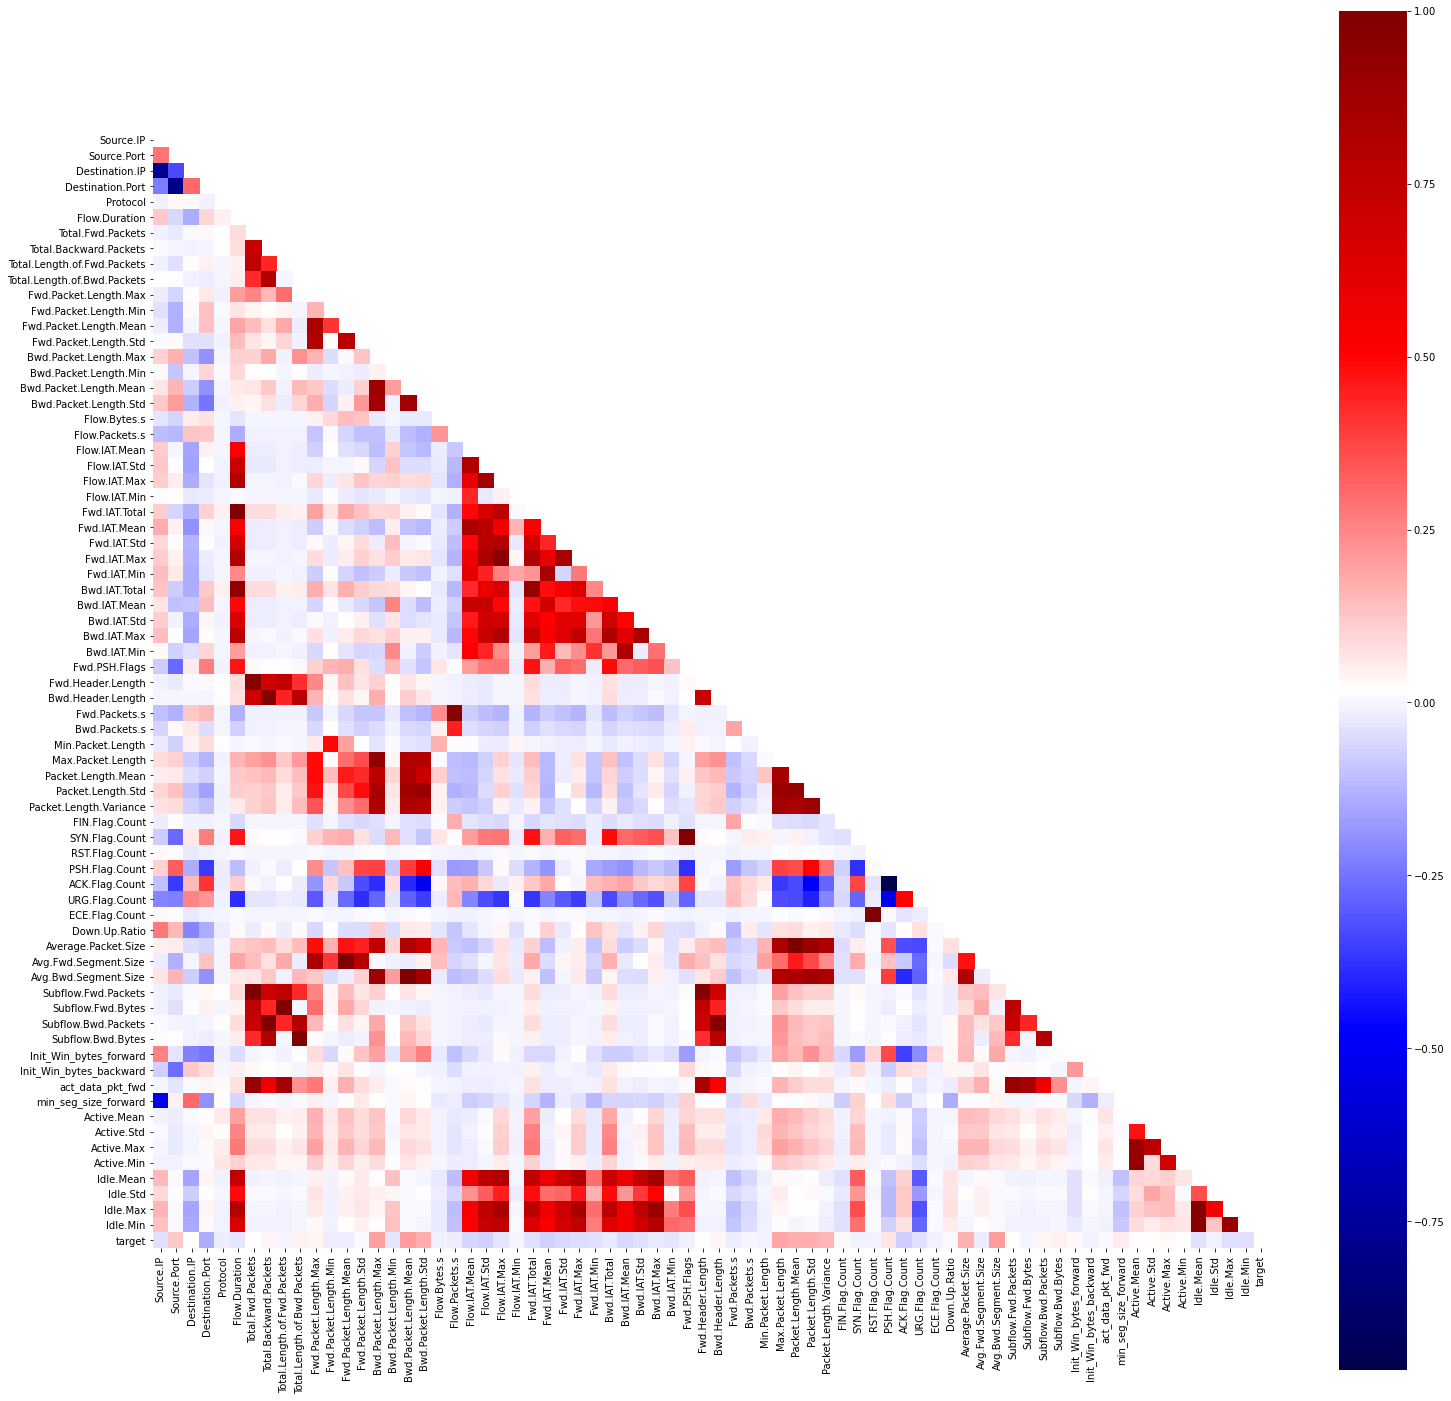

In [8]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(25, 25))
sns.heatmap(corr, square=True, mask=mask, cmap="seismic")

In [9]:
corr_list = (corr.mask(mask)
             .unstack()
             .reset_index()
             .rename(columns={"level_0": "X", "level_1": "Y", 0: "corr(X, Y)"})
             .query("X!=Y")
             .sort_values(by="corr(X, Y)", ascending=False))

In [10]:
corr_list.head()

,X,Y,"corr(X, Y)"
917,Fwd.Packet.Length.Mean,Avg.Fwd.Segment.Size,1.0
1206,Bwd.Packet.Length.Mean,Avg.Bwd.Segment.Size,1.0
706,Total.Length.of.Bwd.Packets,Subflow.Bwd.Bytes,1.0
561,Total.Backward.Packets,Subflow.Bwd.Packets,1.0
487,Total.Fwd.Packets,Subflow.Fwd.Packets,1.0


In [11]:
corr_list[corr_list["corr(X, Y)"] < 1].head(10)

,X,Y,"corr(X, Y)"
3004,Packet.Length.Mean,Average.Packet.Size,0.996527
3362,RST.Flag.Count,ECE.Flag.Count,0.992407
384,Flow.Duration,Fwd.IAT.Total,0.985159
4893,Idle.Mean,Idle.Max,0.977260
540,Total.Backward.Packets,Bwd.Header.Length,0.975856
2649,Bwd.Header.Length,Subflow.Bwd.Packets,0.975856
467,Total.Fwd.Packets,Fwd.Header.Length,0.973890
2575,Fwd.Header.Length,Subflow.Fwd.Packets,0.973890
4894,Idle.Mean,Idle.Min,0.968568
1405,Flow.Packets.s,Fwd.Packets.s,0.963014


In [12]:
corr_list.sort_values(by="corr(X, Y)").head(10)

,X,Y,"corr(X, Y)"
3432,PSH.Flag.Count,ACK.Flag.Count,-0.964378
75,Source.Port,Destination.Port,-0.803233
2,Source.IP,Destination.IP,-0.776931
1272,Bwd.Packet.Length.Std,ACK.Flag.Count,-0.526798
62,Source.IP,min_seg_size_forward,-0.523017
3433,PSH.Flag.Count,URG.Flag.Count,-0.511985
3072,Packet.Length.Std,ACK.Flag.Count,-0.483373
3073,Packet.Length.Std,URG.Flag.Count,-0.408318
1200,Bwd.Packet.Length.Mean,ACK.Flag.Count,-0.395291
3510,ACK.Flag.Count,Avg.Bwd.Segment.Size,-0.395291


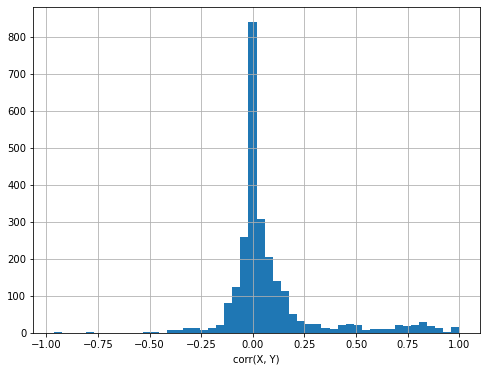

In [13]:
plt.figure(figsize=(8, 6))
plt.xlabel("corr(X, Y)")
corr_list["corr(X, Y)"].hist(bins=50);

In [14]:
protocol_info = (pd.DataFrame(df["ProtocolName"].value_counts())
                 .merge(pd.DataFrame(df["ProtocolName"].value_counts(normalize=True)),
                        left_index=True,
                        right_index=True,
                        suffixes=("Count", "Proportion")))
protocol_info["ProtocolNameCumulativeProportion"] = protocol_info["ProtocolNameProportion"].cumsum()
protocol_info

,ProtocolNameCount,ProtocolNameProportion,ProtocolNameCumulativeProportion
GOOGLE,959028,0.268847,0.268847
HTTP,676263,0.189578,0.458425
HTTP_PROXY,621408,0.174201,0.632626
SSL,404774,0.113471,0.746097
HTTP_CONNECT,317486,0.089002,0.835099
YOUTUBE,170768,0.047872,0.882971
AMAZON,86871,0.024353,0.907323
MICROSOFT,54705,0.015336,0.922659
GMAIL,40256,0.011285,0.933944
WINDOWS_UPDATE,34454,0.009659,0.943603


In [15]:
df.to_parquet("preprocessed_all.parquet")